In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

#### Question 1

In [59]:
def voltage_diff(voltage, args_v):
    leak_potential  = args_v['leak_potential']
    memb_resistance = args_v['membrane_resistance']
    tau_m           = args_v['tau_m']
    synapse_current = args_v['synapse_current']

    return (leak_potential - voltage + memb_resistance * synapse_current) / tau_m

In [85]:
def synapse_spike_chances(synapses_count):
    return np.array([random.uniform(0,1) for i in range(synapses_count)])

In [93]:
def q1_real(args_v, args_s, v_reset, v_threshold, synapses, time=1000, step=0.25):
    reversal_potential      = args_s['reversal_potential']
    peak_conductance        = args_s['g_bar']
    delta_s                 = args_s['delta_s']
    tau_s                   = args_s['tau_s']
    firing_rate             = args_s['firing_rate']

    time = np.linspace(0, time, int(time / step))

    volts = []
    spikes_count = 0
    v = v_reset
    
    s_vec = np.full(synapses, peak_conductance, dtype=float)
    peak_vec = np.full(synapses, peak_conductance, dtype=float)

    for i in time:
        synapse_spikes = synapse_spike_chances(synapses)
        for i, chance in enumerate(synapse_spikes):
            if chance < firing_rate * step:
                s_vec[i] += delta_s
            else:
                s_vec[i] = s_vec[i] - (s_vec[i] * step) / tau_s

        args_v['synapse_current'] = np.sum(s_vec * peak_vec) * (reversal_potential - v)

        v = v + step * voltage_diff(v, args_v)
        
        if (v > v_threshold):
            spikes_count += 1
            v = v_reset
        volts.append(v)
        
    return time, volts, spikes_count

In [101]:
args_v1 = {
    'leak_potential': -65,      # E_L (mV)
    'membrane_resistance': 100, # R_m (mV/nA)
    'tau_m': 10                 # Membrane time constant (ms)
}
v_reset = -65
v_threshold = -50

args_s1 = {
    'reversal_potential': 0,      # E_s (mV)
    'g_bar': 0.004,               # Peak conductance (nA/mV)
    'delta_s': 0.5,               # Conductance gate jump
    'tau_s': 2,                   # Membrane time constant (ms)
    'firing_rate': 0.015          # Spike Frequency (spikes/ms)
}

synapses_count = 40
time, volts, spikes_count = q1_real(args_v1, args_s1, v_reset, v_threshold, synapses_count)
print("spikes_count:", spikes_count)

spikes_count: 18


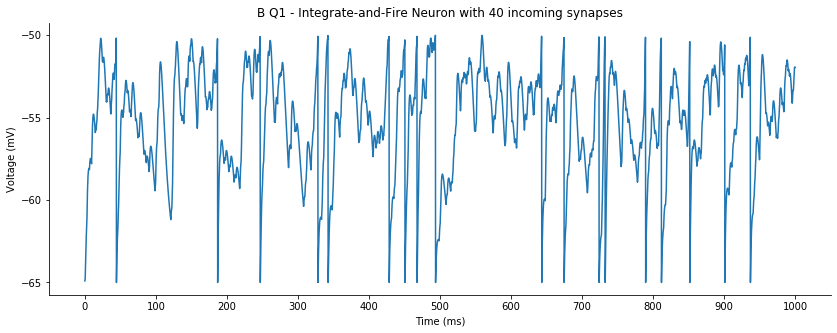

In [102]:
def plot_q1(title, filename, time, volts):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.plot(time, volts)
    ax.set_yticks(range(-65,-45,5))
    ax.set_xticks(range(0,1001,100))
#     fig.savefig(f"plots/{filename}.png", bbox_inches='tight', pad_inches=0.2, dpi=100)
title = "B Q1 - Integrate-and-Fire Neuron with 40 incoming synapses"
plot_q1(title, 'b_q1', time, volts)

#### Question 2
Pre-before-post causes LT-Potentiation

Post-before-pre cuases LT-Depression

In [129]:
def conductance_diff(args_stdp, delta_t):
    a_plus      = args_stdp['a_plus']
    a_minus     = args_stdp['a_minus']
    tau_plus    = args_stdp['tau_plus']
    tau_minus   = args_stdp['tau_minus']
    if delta_t > 0:
        return a_plus * np.exp(-delta_t / tau_plus)
    else:
        return a_minus * np.exp(delta_t / tau_minus)   

In [130]:
def sanitize_conductance(conductance, peak):
    if conductance > peak:
        return peak
    elif  conductance < 0:
        return 0
    else:
        return conductance

In [157]:
def update_conductance(peak_vec, index, delta_t, peak):
    delta_peak = conductance_diff(args_stdp, delta_t)
    peak_vec[index] = sanitize_conductance(peak_vec[index] + delta_peak,
                                           peak)

In [160]:
def q1_stdp(args_v, args_s, args_stdp, time=1000, step=0.25):
    v_reset                 = args_v['v_reset']
    v_threshold             = args_v['v_threshold']
    
    synapses_count          = args_s['synapses_count']
    reversal_potential      = args_s['reversal_potential']
    peak_conductance        = args_s['g_bar']
    delta_s                 = args_s['delta_s']
    tau_s                   = args_s['tau_s']
    firing_rate             = args_s['firing_rate']
    
    stdp                    = args_stdp['enabled']

    time = np.linspace(0, time, int(time / step))

    volts = []
    spikes_count = 0
    v = v_reset
    
    s_vec = np.full(synapses_count, peak_conductance, dtype=float)
    peak_vec = np.full(synapses_count, peak_conductance, dtype=float)
    
    t_pre  = np.full(synapses_count, -1, dtype=float)
    t_post = -1

    for i in time:
        
        synapse_spikes = synapse_spike_chances(synapses_count)
        for j, chance in enumerate(synapse_spikes):
            if chance < firing_rate * step:
                s_vec[j] += delta_s
                t_pre[j] = i
                if stdp:
                    update_conductance(peak_vec, j, t_post - t_pre[j], peak_conductance)
            else:
                s_vec[j] = s_vec[j] - (s_vec[j] * step) / tau_s 

        args_v['synapse_current'] = np.sum(s_vec * peak_vec) * (reversal_potential - v)

        v = v + step * voltage_diff(v, args_v)
        
        if (v > v_threshold):
            spikes_count += 1
            v = v_reset
            t_post = i
            if stdp: update_conductance(peak_vec, j, t_post - t_pre[j], peak_conductance)
        
        volts.append(v)
        
    return time, volts, spikes_count

#### STDP ON

In [161]:
args_v2 = {
    'leak_potential': -65,      # E_L (mV)
    'membrane_resistance': 100, # R_m (mV/nA)
    'tau_m': 10,                # Membrane time constant (ms)
    'v_reset': -65,             # (mV)
    'v_threshold': -50          # (mV)
}

args_s2 = {
    'synapses_count': 40,         # N
    'reversal_potential': 0,      # E_s (mV)
    'g_bar': 0.004,               # Peak conductance (nA/mV)
    'delta_s': 0.5,               # Conductance gate jump
    'tau_s': 2,                   # Membrane time constant (ms)
    'firing_rate': 0.015          # Spike Frequency (spikes/ms)
}

args_stdp = {
    'enabled':   True,        # "ON"
    'a_plus':    0.0002,      # (nA/mV)
    'a_minus':   0.00025,     # (nA/mV)
    'tau_plus':  20,          # (ms)
    'tau_minus': 20           # (ms)
}

time, volts2, spike_counts2 = q1_stdp(args_v2, args_s2, args_stdp, time=100000)
print(spike_counts2)

2138


#### STDP OFF

In [ ]:
# There’s a bit of run to run variability but yeah
# the firing rate towards the end should be low, 
# 1 Hz or less